<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/bart/661_Bart_CARER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bart CARER

This notebook will fine-tune a pretrained Bart model on the Contextualized Affect Representations for Emotion Recognition (CARER) dataset. The performance of the model will serve as one of the baselines with which to compare the performances of the autoregressive models on text classification.

## Setup

In [1]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from transformers import BartTokenizerFast, BartForConditionalGeneration, BartForSequenceClassification
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from time import time

In [3]:
cuda = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
model_size = 'base'

## Dataset

In [5]:
dataset = load_dataset("dair-ai/emotion", "split")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [6]:
for i, val in enumerate(dataset['train']):
    print(val)
    if i == 10:
        break

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}
{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}
{'text': 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'label': 2}
{'text': 'i am feeling grouchy', 'label': 3}
{'text': 'ive been feeling a little burdened lately wasnt sure why that was', 'label': 0}
{'text': 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny', 'label': 5}
{'text': 'i feel as confused about life as a teenager or as jaded as a year old man', 'label': 4}
{'text': 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'label': 1}
{'text': 'i feel romantic too', 'label': 2}
{'text': 'i feel like i have to make the suffering i m seeing mean something', 'la

## Bart Sequence Classification

Performance of sequence classification will be used merely as a comparison to text generation.

In [7]:
tokenizer = BartTokenizerFast.from_pretrained(f'facebook/bart-{model_size}')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [8]:
def tokenize_data(data):
  return tokenizer(
      data["text"],
      padding="max_length",
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )

In [9]:
tokenized_dataset = dataset.map(tokenize_data, batched=True)
print(tokenized_dataset)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [10]:
for i, val in enumerate(tokenized_dataset['train']):
    print(val)
    if i == 10:
        break

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [0, 118, 46405, 619, 32386, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0, 'inp

In [11]:
lengths = []
for i, val in enumerate(tokenized_dataset['train']):
  input_ids = val["input_ids"]
  no_pad = [token for token in input_ids if token != 0]
  lengths.append(len(no_pad))
lengths = np.array(lengths)
print(lengths.mean(), lengths.max(), lengths.min())

127.0 127 127


In [12]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### Dataset split

In [13]:
train_ds = tokenized_dataset["train"]
val_ds = tokenized_dataset["validation"]
test_ds = tokenized_dataset["test"]

In [14]:
for i, val in enumerate(test_ds):
    print(val['label'])
    if i == 10:
        break

tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(4)
tensor(3)
tensor(1)
tensor(1)
tensor(3)
tensor(4)


In [15]:
unique, counts = np.unique(train_ds['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 4666, 1: 5362, 2: 1304, 3: 2159, 4: 1937, 5: 572}


In [16]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [17]:
model = BartForSequenceClassification.from_pretrained(f"facebook/bart-{model_size}", num_labels=len(unique))
model.to(cuda)
print(model)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartForSequenceClassification(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_la

In [18]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
len(train_loader)

500

In [20]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = loss_fn(outputs.logits.squeeze(), labels)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval - 1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_loader:
      input_ids = batch["input_ids"].to(cuda)
      attention_mask = batch["attention_mask"].to(cuda)
      labels = batch["label"].to(cuda)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      preds = torch.argmax(outputs.logits, dim=1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")
print("Training finished")

Epoch 1/5, Batch 100/500, Loss: 1.494
Time elapsed: 20.124s
Epoch 1/5, Batch 200/500, Loss: 0.935
Time elapsed: 38.446s
Epoch 1/5, Batch 300/500, Loss: 0.620
Time elapsed: 56.816s
Epoch 1/5, Batch 400/500, Loss: 0.490
Time elapsed: 75.131s
Epoch 1/5, Batch 500/500, Loss: 0.354
Time elapsed: 93.454s
Epoch 1/5, Validation Accuracy: 0.887
Epoch 2/5, Batch 100/500, Loss: 0.221
Time elapsed: 115.226s
Epoch 2/5, Batch 200/500, Loss: 0.189
Time elapsed: 133.116s
Epoch 2/5, Batch 300/500, Loss: 0.164
Time elapsed: 150.998s
Epoch 2/5, Batch 400/500, Loss: 0.162
Time elapsed: 168.892s
Epoch 2/5, Batch 500/500, Loss: 0.148
Time elapsed: 186.783s
Epoch 2/5, Validation Accuracy: 0.933
Epoch 3/5, Batch 100/500, Loss: 0.107
Time elapsed: 208.498s
Epoch 3/5, Batch 200/500, Loss: 0.113
Time elapsed: 226.389s
Epoch 3/5, Batch 300/500, Loss: 0.107
Time elapsed: 244.283s
Epoch 3/5, Batch 400/500, Loss: 0.107
Time elapsed: 262.157s
Epoch 3/5, Batch 500/500, Loss: 0.107
Time elapsed: 280.048s
Epoch 3/5, Val

### Inference

In [21]:
model.eval()
with torch.no_grad():
  all_preds = []
  all_labels = []
  for batch in test_loader:
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # take the highest-probability class for multiclass prediction
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       581
           1       0.95      0.95      0.95       695
           2       0.86      0.78      0.82       159
           3       0.93      0.92      0.92       275
           4       0.89      0.90      0.89       224
           5       0.82      0.74      0.78        66

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



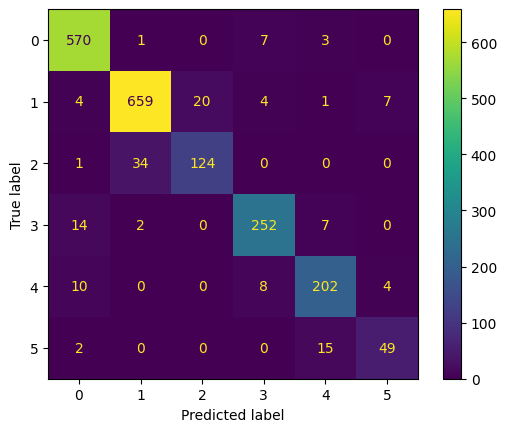

In [22]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
torch.save(model.state_dict(), f"bart-{model_size}-emotion-classification.pt")

In [24]:
from google.colab import files
files.download(f"bart-{model_size}-emotion-classification.pt")
print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started


## Bart Conditional Generation

Performance of conditional generation will be measured as a baseline performance, as the task more closely resembles the task of sentiment generation for the autoregressive models.

In [ ]:
torch.cuda.empty_cache()

### Tokenizer

In [25]:
prefix = "Classify the emotion of the following text: "
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]
train_ds = train_ds.map(lambda x: {"text": prefix + x["text"]})
val_ds = val_ds.map(lambda x: {"text": prefix + x["text"]})
test_ds = test_ds.map(lambda x: {"text": prefix + x["text"]})

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def map_labels(data):
  data["emotion"] = label_map[data["label"]]
  return data

train_ds = train_ds.map(map_labels)
val_ds = val_ds.map(map_labels)
test_ds = test_ds.map(map_labels)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
for i, val in enumerate(train_ds):
    print(val)
    if i == 10:
        break

{'text': 'Classify the emotion of the following text: i didnt feel humiliated', 'label': 0, 'emotion': 'sadness'}
{'text': 'Classify the emotion of the following text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0, 'emotion': 'sadness'}
{'text': 'Classify the emotion of the following text: im grabbing a minute to post i feel greedy wrong', 'label': 3, 'emotion': 'anger'}
{'text': 'Classify the emotion of the following text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'label': 2, 'emotion': 'love'}
{'text': 'Classify the emotion of the following text: i am feeling grouchy', 'label': 3, 'emotion': 'anger'}
{'text': 'Classify the emotion of the following text: ive been feeling a little burdened lately wasnt sure why that was', 'label': 0, 'emotion': 'sadness'}
{'text': 'Classify the emotion of the following text: ive been taking or milligrams or times recommended 

In [31]:
for i in label_map:
  print(tokenizer(label_map[i]))

{'input_ids': [0, 29, 625, 1825, 2], 'attention_mask': [1, 1, 1, 1, 1]}
{'input_ids': [0, 20768, 2], 'attention_mask': [1, 1, 1]}
{'input_ids': [0, 17693, 2], 'attention_mask': [1, 1, 1]}
{'input_ids': [0, 8395, 2], 'attention_mask': [1, 1, 1]}
{'input_ids': [0, 506, 4352, 2], 'attention_mask': [1, 1, 1, 1]}
{'input_ids': [0, 12557, 22627, 2], 'attention_mask': [1, 1, 1, 1]}


In [32]:
def tokenize_data(data):
  inputs = tokenizer(
      data["text"],
      padding="max_length",
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )
  labels = tokenizer(
      data["emotion"],
      padding="max_length",
      truncation=True,
      max_length=5,
      return_tensors="pt"
  )
  inputs["label"] = labels["input_ids"]
  return inputs

In [33]:
train_tokenized = train_ds.map(tokenize_data, batched=True)
val_tokenized = val_ds.map(tokenize_data, batched=True)
test_tokenized = test_ds.map(tokenize_data, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
for i, val in enumerate(train_tokenized):
    print(val)
    if i == 10:
        break

{'text': 'Classify the emotion of the following text: i didnt feel humiliated', 'label': [0, 29, 625, 1825, 2], 'emotion': 'sadness', 'input_ids': [0, 21527, 4591, 5, 11926, 9, 5, 511, 2788, 35, 939, 46405, 619, 32386, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'text': 'Classify the emotion of 

In [35]:
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [36]:
unique, counts = np.unique(train_tokenized['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 16000, 1: 20159, 2: 16000, 29: 4666, 506: 1937, 625: 4666, 1825: 4666, 4352: 1937, 8395: 2159, 12557: 572, 17693: 1304, 20768: 5362, 22627: 572}


In [37]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_tokenized, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [58]:
model = BartForConditionalGeneration.from_pretrained(f"facebook/bart-{model_size}")
model.to(cuda)
print(model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [59]:
epochs = 4
optimizer = AdamW(model.parameters(), lr=5e-5)

In [60]:
emotion_map = dict(zip(label_map.values(), label_map.keys()))
emotion_map

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [61]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
print("Training started")
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval-1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    all_texts = []
    all_preds = []
    all_labels = []
    for batch in val_loader:
      input_ids = batch["input_ids"].to(cuda)
      attention_mask = batch["attention_mask"].to(cuda)
      outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=8)
      preds = [emotion_map[pred] for pred in tokenizer.batch_decode(outputs, skip_special_tokens=True)]
      labels = [emotion_map[label] for label in tokenizer.batch_decode(batch["label"], skip_special_tokens=True)]
      total += len(labels)
      correct += (np.array(preds) == np.array(labels)).sum()
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")

print("Training finished")

Training started
Epoch 1/4, Batch 100/500, Loss: 1.540
Time elapsed: 11.425s
Epoch 1/4, Batch 200/500, Loss: 0.206
Time elapsed: 22.337s
Epoch 1/4, Batch 300/500, Loss: 0.147
Time elapsed: 33.241s
Epoch 1/4, Batch 400/500, Loss: 0.092
Time elapsed: 44.163s
Epoch 1/4, Batch 500/500, Loss: 0.062
Time elapsed: 55.014s
Epoch 1/4, Validation Accuracy: 0.914
Epoch 2/4, Batch 100/500, Loss: 0.034
Time elapsed: 83.251s
Epoch 2/4, Batch 200/500, Loss: 0.033
Time elapsed: 93.810s
Epoch 2/4, Batch 300/500, Loss: 0.031
Time elapsed: 104.332s
Epoch 2/4, Batch 400/500, Loss: 0.030
Time elapsed: 114.897s
Epoch 2/4, Batch 500/500, Loss: 0.027
Time elapsed: 125.451s
Epoch 2/4, Validation Accuracy: 0.939
Epoch 3/4, Batch 100/500, Loss: 0.023
Time elapsed: 153.640s
Epoch 3/4, Batch 200/500, Loss: 0.022
Time elapsed: 164.197s
Epoch 3/4, Batch 300/500, Loss: 0.022
Time elapsed: 174.752s
Epoch 3/4, Batch 400/500, Loss: 0.026
Time elapsed: 185.304s
Epoch 3/4, Batch 500/500, Loss: 0.021
Time elapsed: 195.861s

### Inference

In [62]:
model.eval()
with torch.no_grad():
  all_texts = []
  all_preds = []
  all_labels = []
  for batch in test_loader:
    outputs = model.generate(input_ids=batch["input_ids"].to(cuda), attention_mask=batch["attention_mask"].to(cuda), max_length=8)
    all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
    all_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    all_labels.extend(tokenizer.batch_decode(batch["label"], skip_special_tokens=True))

In [ ]:
for i in range(10):
  print("Sentence: " + all_texts[i])
  print("Predicted sentiment: " + all_preds[i])
  print("Actual sentiment: " + all_labels[i])

In [64]:
preds = [emotion_map[pred] for pred in all_preds]
labels = [emotion_map[label] for label in all_labels]

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       581
           1       0.91      0.99      0.95       695
           2       0.98      0.67      0.80       159
           3       0.90      0.95      0.92       275
           4       0.86      0.94      0.90       224
           5       0.95      0.58      0.72        66

    accuracy                           0.93      2000
   macro avg       0.93      0.85      0.88      2000
weighted avg       0.93      0.93      0.93      2000



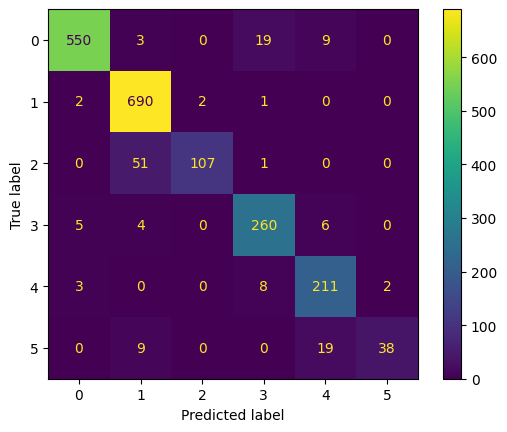

In [66]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Interestingly, the text classification model slightly outperforms the text generation model. The generation model obtains a higher precision score, while the classification model obtains higher recall and f1 scores. Both models obtain equal accuracy, but the class imbalance in the dataset makes accuracy an unreliable metric.

In [67]:
torch.save(model.state_dict(), f"bart-{model_size}-emotion-generation.pt")

In [68]:
files.download(f"bart-{model_size}-emotion-generation.pt")
print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started
